In [73]:
import numpy as np
import matplotlib.pyplot as plt

In [74]:
n_states = 4
k_actions = 2
gamma = 0.95
n_rounds = 10**6
epsilon = 0.2

In [75]:
float_formatter = "{:.3f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})


In [76]:
#Inspiration from https://github.com/aa14k/Exploration-in-RL/blob/master/Exploration_Project_RL1/Beyond_UCB.ipynb

class RiverSwim():

    def __init__(self, nState, nAction, alpha):
       
        self.nStates = nState
        self.nActions = nAction
        self.alpha = alpha

        R = {}
        P = {}
        states = {}
        for s in range(nState):
            states[(s)] = 0.0
            for a in range(nAction):
                R[s, a] = 0
                P[s, a] = np.zeros(nState)
        
        # Rewards
        #Could delete this i am not using the R values any way
        R[0, 0] = alpha
        R[nState - 1, 1] = 1

        # Transitions
        for s in range(nState):
            P[s, 0][max(0, s-1)] = 1.

        for s in range(1, nState - 1):
            P[s, 1][min(nState - 1, s + 1)] = 0.4
            P[s, 1][s] = 0.55
            P[s, 1][max(0, s-1)] = 0.05

        #Set the Probabilities for the first and last state
        P[0, 1][0] = 0.4
        P[0, 1][1] = 0.6
        P[nState - 1, 1][nState - 1] = 0.6
        P[nState - 1, 1][nState - 2] = 0.4

        self.Rewards = R
        self.Probabilities = P
        self.states = states
        self.state = 0

    def reset(self):
        self.state = 0

    def advance(self,action):
        if self.state == 0 and action == 0:
            reward = self.alpha
        elif self.state == self.nStates - 1:
            #We are in the max state
            reward = 1
        else:
            reward = 0
            
        newState = np.random.choice(self.nStates, p=self.Probabilities[self.state, action])

        # Update the environment
        self.state = newState

        return reward, newState

riverSwim = RiverSwim(n_states, k_actions, 0.05)
riverSwim.Probabilities

{(0, 0): array([1.000, 0.000, 0.000, 0.000]),
 (0, 1): array([0.400, 0.600, 0.000, 0.000]),
 (1, 0): array([1.000, 0.000, 0.000, 0.000]),
 (1, 1): array([0.050, 0.550, 0.400, 0.000]),
 (2, 0): array([0.000, 1.000, 0.000, 0.000]),
 (2, 1): array([0.000, 0.050, 0.550, 0.400]),
 (3, 0): array([0.000, 0.000, 1.000, 0.000]),
 (3, 1): array([0.000, 0.000, 0.400, 0.600])}

In [77]:
riverSwim.Rewards

{(0, 0): 0.05,
 (0, 1): 0,
 (1, 0): 0,
 (1, 1): 0,
 (2, 0): 0,
 (2, 1): 0,
 (3, 0): 0,
 (3, 1): 1}

In [78]:
def get_opt_policy(Q, n_states):
    pi = []
    for state in range(n_states):
        opt_action = np.argmax(Q[state])
        pi.append(opt_action)
    return pi

In [79]:
r_pi = np.array([0.05,0,0,1])

p_pi = np.array([[0.6,0.4,0,0],
                 [0.05,0.55,0.4,0],
                 [0,0.05,0.55,0.4],
                 [0,0,0.4,0.6]])

V_pi = np.dot(np.linalg.inv(np.identity(n_states)- gamma * p_pi), r_pi)

print(V_pi)

[6.930 7.710 8.822 10.122]


In [80]:
def q_star_helper(river_swim, V_pi, n_states, state, action):
    sum_ = 0.0
    for x in range(n_states):
        sum_ += river_swim.Probabilities[state,action][x] * V_pi[x]
    return sum_

In [81]:
def q_star(river_swim, gamma, n_states, k_actions, V_pi):
    Q = np.zeros((n_states, k_actions))
    for s in range(n_states):
        for a in range(k_actions):
            #print(q_star_helper(river_swim, Q, n_states, s, a))
            Q[s,a] = river_swim.Rewards[(s,a)] + gamma * q_star_helper(river_swim, V_pi, n_states, s, a)
    return Q
Q_star = q_star(riverSwim, gamma, n_states, k_actions, V_pi)
print(Q_star)
print(get_opt_policy(Q_star, n_states))

[[6.633 7.028]
 [6.583 7.710]
 [7.324 8.822]
 [8.381 10.122]]
[1, 1, 1, 1]


In [82]:
def q_learning_a(river_swim, T, gamma, n_states, k_actions):
    Qs = []
    Q_t = np.zeros((n_states, k_actions))
    state =  river_swim.state
    
    for t in range(1,T+1):
        action = np.random.binomial(1, 0.5)
        
        alpha = 10/(t**(2/3)+1)
        
        r_t, next_state = river_swim.advance(action)
        #print(f'state = {state}, action = {action}, next_state = {next_state}, r_t = {r_t}')
        #print(f'river_swim.state = {river_swim.state}')
        delta = r_t + gamma * np.max(Q_t[next_state])-Q_t[state, action]
        #print(f'delta = {delta}')
        Q_t[state, action] = Q_t[state, action] + alpha*delta
        
        state =  next_state
        Qs.append(Q_t.copy())
    return Qs

Qa = q_learning_a(riverSwim, n_rounds, gamma, n_states, k_actions)

In [83]:
print(Qa[-1])
print(get_opt_policy(Qa[-1],n_states))

[[6.614 6.919]
 [6.563 7.529]
 [7.148 8.598]
 [9.154 9.871]]
[1, 1, 1, 1]


In [84]:
def q_learning_b(river_swim, T, gamma, n_states, k_actions):
    Qs = []
    Q_t = np.zeros((n_states, k_actions))
    state = river_swim.state
    
    N_t = np.zeros(shape = (n_states,k_actions))
    
    for t in range(1,T+1):
        action = np.random.binomial(1, 0.5)
        
        N_t[state, action] += 1
        alpha = 10/(N_t[state, action]**(2/3)+1)
        
        r_t, next_state = river_swim.advance(action)
        #print(f'action = {action}')
        #print(f'river_swim.state = {river_swim.state}')
        delta = r_t + gamma * np.max(Q_t[next_state])-Q_t[state, action]
        Q_t[state, action] = Q_t[state, action] + alpha*delta
        #Q_t[state, sample_action] += lr*(r + gamma * np.max(Q[new_state]-Q[state, sample_action]))
        #print(Q)
        state =  next_state
        Qs.append(Q_t.copy())
                                        
    return Qs

Qb = q_learning_b(riverSwim, n_rounds, gamma, n_states, k_actions)

In [85]:
print(Qb[-1])
print(get_opt_policy(Qb[-1],n_states))

[[7.062 7.359]
 [7.016 7.965]
 [7.593 9.121]
 [9.646 10.438]]
[1, 1, 1, 1]


In [86]:
def promotion(state, action, N, B, n_states, k_actions):
    for s in range(n_states):
        for a in range(k_actions):
            if s == state and a == action:
                B[s,a] = 0
            elif s == state and a != action:
                B[s,a] = B[s,a] + 1/np.max([N[s,a],1])
            elif s != state and a != action:
                B[s,a] = B[s,a]
    return B


In [87]:
def epsilon_greddy_policy(epsilon, Q, B, state):
    if np.random.random() < epsilon:
        action = np.random.binomial(1, 0.5)
    else:
        action = np.argmax(Q[state]+B[state])

    return action

In [88]:
def q_inc_learning_a(river_swim, T, gamma, epsilon, n_states, k_actions):
    Qs = []
    Q_t = np.zeros((n_states, k_actions))
    state = river_swim.state
    
    N_t = np.zeros(shape = (n_states,k_actions))
    B = np.zeros(shape = (n_states,k_actions))
    
    for t in range(1,T+1):
        action = epsilon_greddy_policy(epsilon, Q_t, B, state)
        
        N_t[state, action] += 1
        alpha = 10/(t**(2/3)+1)
        
        r_t, next_state = river_swim.advance(action)
        #print(f'state = {state}, action = {action}, next_state = {next_state}, r_t = {r_t}')
        
        delta = r_t + gamma * np.max(Q_t[next_state])-Q_t[state, action]
        Q_t[state, action] = Q_t[state, action] + alpha*delta
        
        B = promotion(state, action, N_t, B, n_states, k_actions)
        #print(B)
        #print(Q_t)
        
        state =  next_state
        Qs.append(Q_t.copy())
        
    return Qs

Q_inc_a = q_inc_learning_a(riverSwim, n_rounds, gamma,epsilon, n_states, k_actions)

In [89]:
print(Q_inc_a[-1])
print(get_opt_policy(Q_inc_a[-1],n_states))

[[6.808 7.133]
 [6.772 7.755]
 [7.365 8.823]
 [9.409 10.153]]
[1, 1, 1, 1]


In [90]:
def q_inc_learning_b(river_swim, T, gamma, epsilon, n_states, k_actions):
    Qs = []
    Q_t = np.zeros((n_states, k_actions))
    state = river_swim.state
    
    N_t = np.zeros(shape = (n_states,k_actions))
    B = np.zeros(shape = (n_states,k_actions))
    
    for t in range(1,T+1):
        action = epsilon_greddy_policy(epsilon, Q_t, B, state)

        N_t[state, action] += 1
        alpha = 10/(N_t[state, action]**(2/3)+1)
        
        r_t, next_state = river_swim.advance(action)
        #print(f'state = {state}, action = {action}, next_state = {next_state}, r_t = {r_t}')
        
        delta = r_t + gamma * np.max(Q_t[next_state])-Q_t[state, action]
        Q_t[state, action] = Q_t[state, action] + alpha*delta
        
        B = promotion(state, action, N_t, B, n_states, k_actions)
        
        state =  next_state
        Qs.append(Q_t.copy())
                                        
    return Qs

Q_inc_b = q_inc_learning_b(riverSwim, n_rounds, gamma, epsilon, n_states, k_actions)

In [91]:
print(Q_inc_b[-1])
print(get_opt_policy(Q_inc_b[-1],n_states))

[[6.841 7.140]
 [6.792 7.771]
 [7.392 8.884]
 [9.424 10.160]]
[1, 1, 1, 1]


In [96]:
def plot_experiments_all(Q_star, q_a, q_b, q_inc_a, q_inc_b):
    
    q_a_errors = []
    q_inc_a_errors = []
    
    
    q_b_errors = []
    q_inc_b_errors = []
    
    
    for t in range(len(q_a)):
        q_a_errors.append(np.linalg.norm((Q_star-q_a[t]), np.inf))
        q_inc_a_errors.append(np.linalg.norm((Q_star-q_inc_a[t]), np.inf))
        q_b_errors.append(np.linalg.norm((Q_star-q_b[t]), np.inf))
        q_inc_b_errors.append(np.linalg.norm((Q_star-q_inc_b[t]), np.inf))

    
    plt.figure(figsize=(16, 9))
        
    plt.title('Plot of errors $\|\|Q^{*}-Q_T \|\|_{\infty}$ for Q-Learning and Incremental Q-Learning')
    
    plt.plot(range(len(q_a)), q_a_errors, label="Q-Learning $\\alpha_{t}=10/(t^{\\frac{2}{3}}+1)$")
    plt.plot(range(len(q_a)), q_inc_a_errors, label="Incremental Q-Learning with $\\alpha_{t}=10/(t^{\\frac{2}{3}}+1)$")
    plt.plot(range(len(q_a)), q_b_errors, label="Q-Learning with $\\alpha_{t}=10/(N_{t}(s_{t}, a_{t})^{2 / 3}+1)$ ")
    plt.plot(range(len(q_a)), q_inc_b_errors, label="Incremental Q-Learning with $\\alpha_{t}=10/(N_{t}(s_{t}, a_{t})^{2 / 3}+1)$ ")
    
    plt.ylabel('$\|\|Q^{*}-Q_T \|\|_{\infty}$')
    plt.xlabel('T')
    plt.legend()
    fname = f'plots/Q-Learning_error_all.png'
    plt.savefig(fname)
    plt.show()

def plot_experiments_single(Q_star, Qs_a, Qs_b, name):
    
    Q_a_errors = []
    Q_b_errors = []
    
    
    for t in range(len(Qs_a)):
        Q_a_errors.append(np.linalg.norm((Q_star-Qs_a[t]), np.inf))
        Q_b_errors.append(np.linalg.norm((Q_star-Qs_b[t]), np.inf))

    
    plt.figure(figsize=(16, 9))
        
    plt.title('Plot of errors $\|\|Q^{*}-Q_T \|\|_{\infty}$ for ' + name + ' Q-Learning')
    
    plt.plot(range(len(Qs_a)), Q_a_errors, label="Q-Learning $\\alpha_{t}=10/(t^{\\frac{2}{3}}+1)$")
    #plt.plot(range(len(Qs_a)), Q_a_errors, label="Incremental Q-Learning with $\\alpha_{t}=10/(t^{\\frac{2}{3}}+1)$")
    plt.plot(range(len(Qs_a)), Q_b_errors, label="Q-Learning with $\\alpha_{t}=10/(N_{t}(s_{t}, a_{t})^{2 / 3}+1)$ ")
    #plt.plot(range(len(q_a)), Q_b_errors, label="Incremental Q-Learning with $\\alpha_{t}=10/(N_{t}(s_{t}, a_{t})^{2 / 3}+1)$ ")
    
    plt.ylabel('$\|\|Q^{*}-Q_T \|\|_{\infty}$')
    plt.xlabel('T')
    plt.legend()
    plt.yscale('log')

    fname = f'plots/Q-Learning_error_{name}.png'
    plt.savefig(fname)
    plt.show()
    


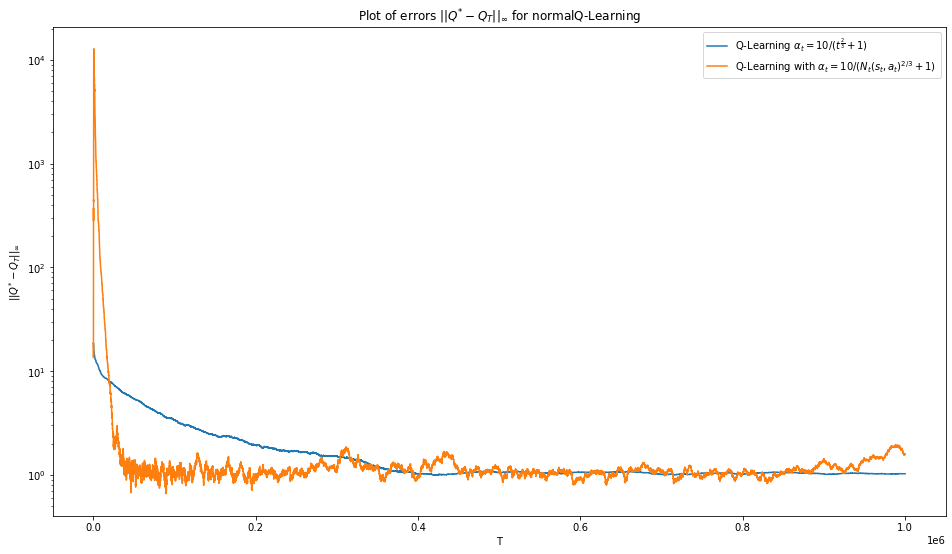

In [100]:
plot_experiments_single(Q_star, Qa, Qb, "normal")

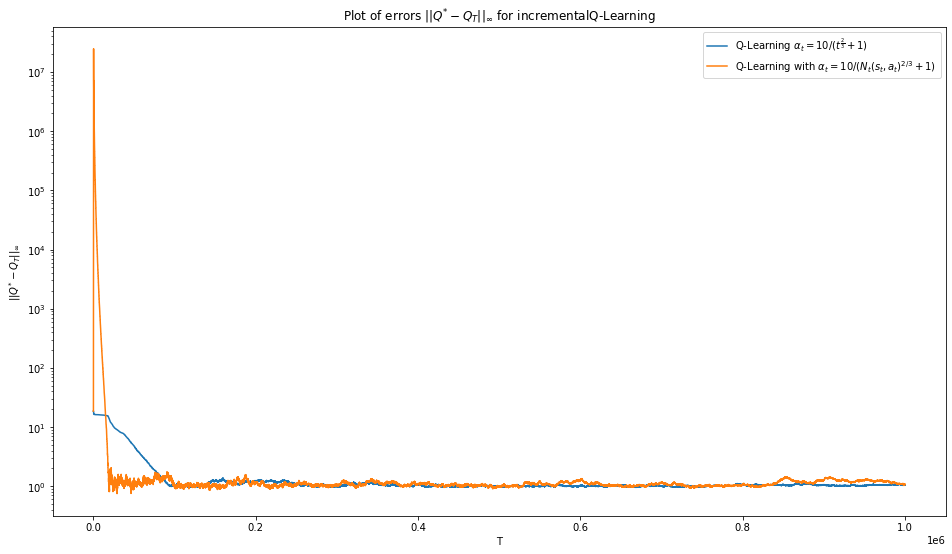

In [99]:
plot_experiments_single(Q_star, Q_inc_a, Q_inc_b, "incremental")

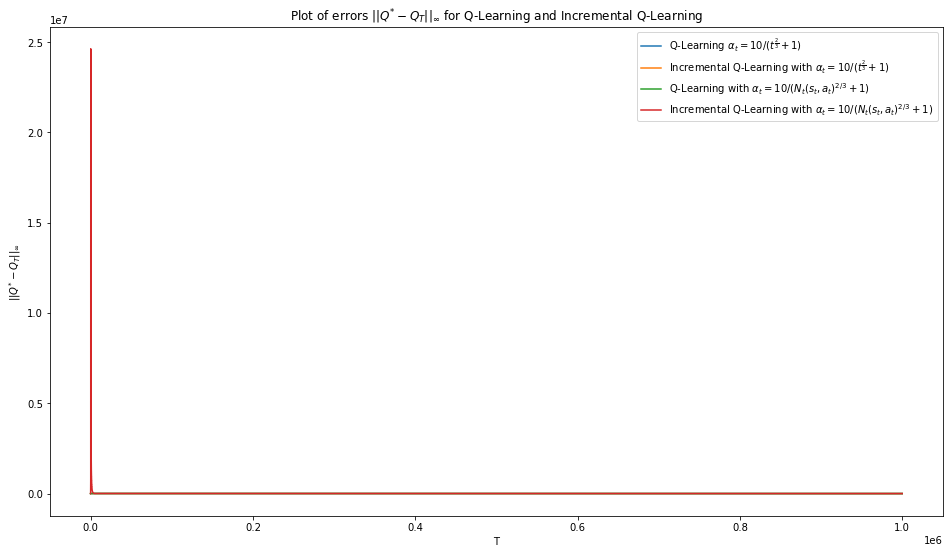

In [95]:
plot_experiments_all(Q_star, Qa, Qb, Q_inc_a, Q_inc_b )